In [1]:
%matplotlib widget
import numpy as np
import json
import os, math, glob
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Load the full scan

In [3]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [43]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_Izero = channel_Izero117

#######################################################################################################33

(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
 Izero_pump, Izero_unpump, correlation, waveplate, goodshots) = XAS_scan_1diode(fc.selected, detector_XAS_1, detector_Izero, quantile_corr)


Processing: run0006
Step 12 of 12: Processing acq0012

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 1991 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1991 / 2001 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 990 pump and 990 unpump shots
(258,) shots out of (990,) survived
Step 12 of 12: Processed acq0012
correlation Diode (all shots) = 0.9975612034859944


In [44]:
#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
#waveplate2 = 0.12612736 + 66.03399024*(np.cos(np.pi/180.*(waveplate - 60.29428308)))**2

#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
waveplate2 = 0.167279498 + 40.7745686*(np.cos(np.pi/180.*(waveplate - 240.744133)))**2    ##calibration from 3.12 in the night

p1 = -401.8889804    
p2 = -3.35660312  
p3 = 12.1638586 

intensity = p2 + p3*(np.cos(np.pi/180.*(waveplate - p1)))**2 
intensity = (p2 + p3*(np.cos(np.pi/180.*(waveplate - p1)))**2 )*1e-3/(2.45*1e-5)# mJ/cm2

# Plot Fluence scan

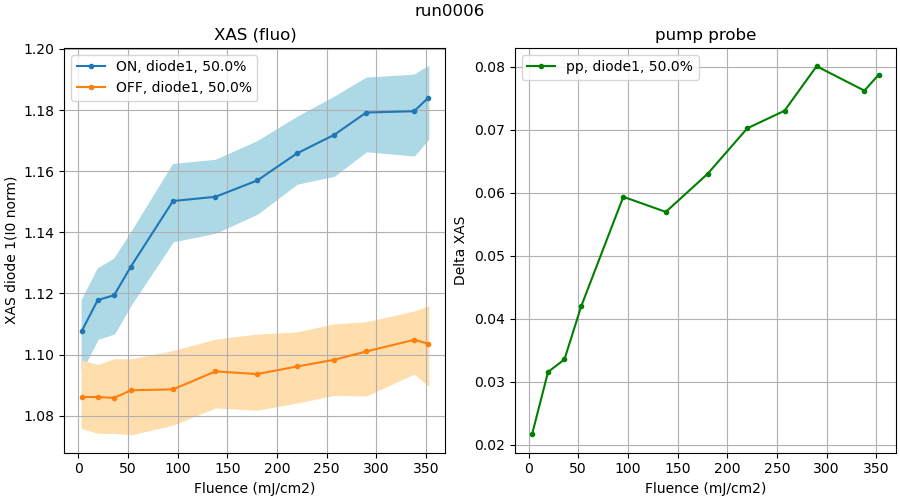

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(intensity, XAS_pump, label='ON, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(intensity, XAS_unpump, label='OFF, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Fluence (mJ/cm2)")
ax1.set_ylabel ("XAS diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(intensity, XAS_pump_probe, label='pp, diode1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
#ax2.fill_between(intensity, err_low_pump_probe, err_high_pump_probe, color='lightgreen')
#ax2.axes.errorbar(intensity, XAS_pump_probe, (XAS_pump_probe-err_low_pump_probe), (err_high_pump_probe-XAS_pump_probe), 
            # lw=1,color='green', markersize=0,capsize=3,capthick=1,
            #      ecolor='green',elinewidth=1)

ax2.set_xlabel("Fluence (mJ/cm2)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

<IPython.core.display.Javascript object>


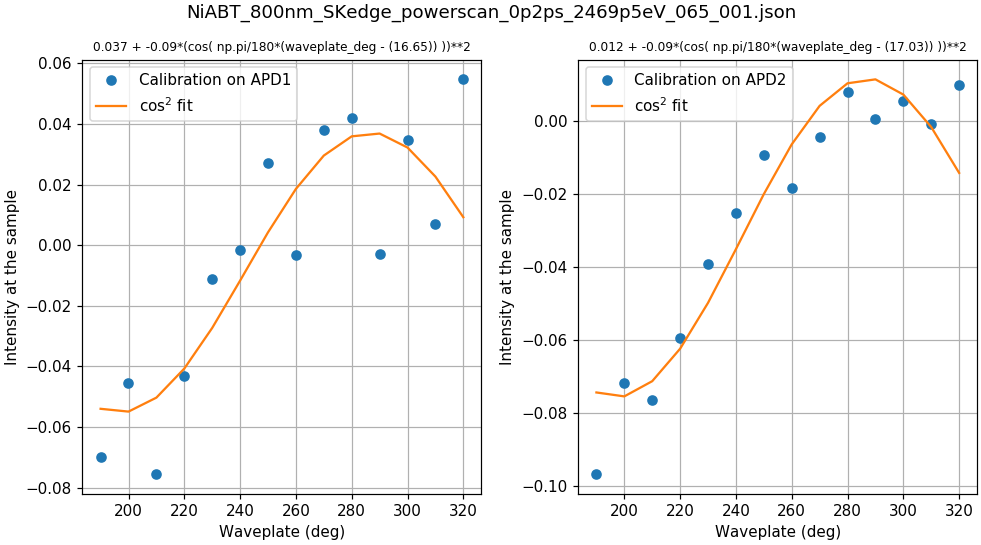

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

xdata = filter_deg
ydata = XAS_APD1_pump_probe

def cosine_fit(xdata, xshift, yshift, yscale):
    return yshift + yscale*(np.cos(np.pi/180.*(xdata - xshift)))**2

popt, pcov = curve_fit(cosine_fit, xdata, ydata)
ax1_title = ('{:.3f} + {:.2f}*(cos( np.pi/180*(waveplate_deg - ({:.2f})) ))**2'.format(popt[1],popt[2],popt[0]))

ax1.set_title(ax1_title, fontsize=8)
ax1.plot(xdata, ydata, 'o', label='Calibration on APD1', linestyle='none')
ax1.plot(xdata, cosine_fit(xdata, *popt), label=r'cos$^2$ fit')

ax1.set_xlabel('Waveplate (deg)')
ax1.set_ylabel('Intensity at the sample')

ax1.grid()
ax1.legend()


xdata = filter_deg
ydata = XAS_APD2_pump_probe

def cosine_fit(xdata, xshift, yshift, yscale):
    return yshift + yscale*(np.cos(np.pi/180.*(xdata - xshift)))**2

popt, pcov = curve_fit(cosine_fit, xdata, ydata)
ax2_title = ('{:.3f} + {:.2f}*(cos( np.pi/180*(waveplate_deg - ({:.2f})) ))**2'.format(popt[1],popt[2],popt[0]))

ax2.set_title(ax2_title, fontsize=8)
ax2.plot(xdata, ydata, 'o', label='Calibration on APD2', linestyle='none')
ax2.plot(xdata, cosine_fit(xdata, *popt), label=r'cos$^2$ fit')

ax2.set_xlabel('Waveplate (deg)')
ax2.set_ylabel('Intensity at the sample')

ax2.grid()
ax2.legend()

plt.show()

In [ ]:
##Gentec reading 

[100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 270 290]


<IPython.core.display.Javascript object>


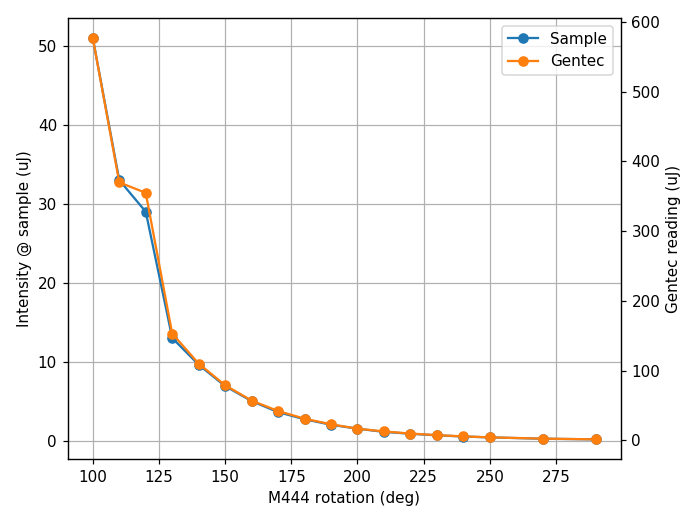

In [35]:
m444 = np.arange(100,300,10)
m444 = np.delete(m444, [-2, -4])
print(m444)
gen = np.array([577, 370, 355, 153, 110, 79, 57, 42, 31, 23, 16.7, 12.7, 9.7, 7.4, 5.6, 4.2, 2.42, 1.36])
sample = np.array([51,33,29, 13, 9.6, 6.9, 5.0, 3.6, 2.7, 2.0, 1.5, 1.1, 0.86, 0.66, 0.51, 0.40, 0.23, 0.15])

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

lns1 = ax1.plot(m444, sample, 'o-', label='Sample')
lns2 = ax2.plot(m444, gen, 'o-',label='Gentec')

ax1.set_xlabel('M444 rotation (deg)')
ax2.set_ylabel('Gentec reading (uJ)')
ax1.set_ylabel('Intensity @ sample (uJ)')

# ax1.set_ylim(0,12)
# ax2.set_ylim(0,36)

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')
ax1.grid()

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


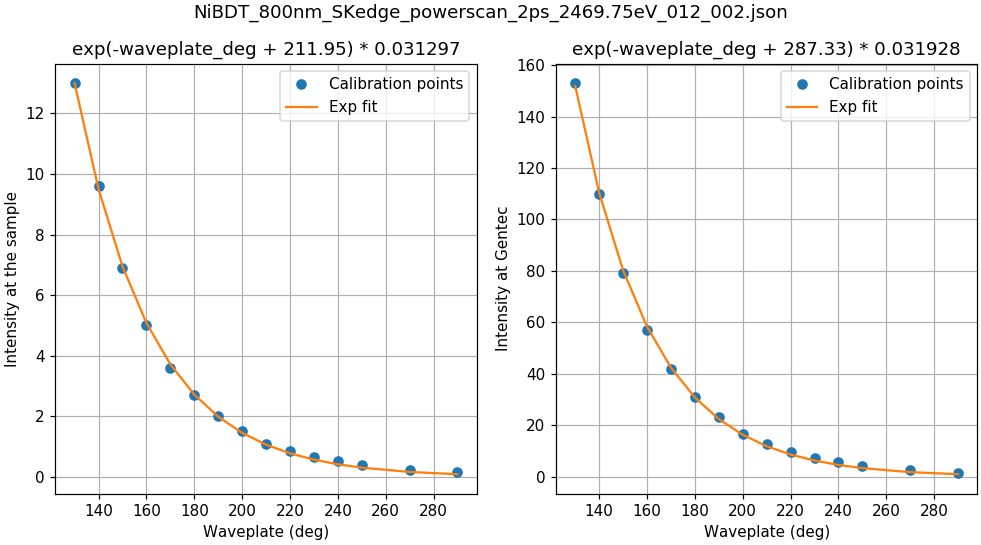

In [126]:
def exp_fit(xdata, xshift, a):
    return (np.exp(  (- xdata + xshift)*a  ))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

xdata = m444[3:]
ydata = gen[3:]

xgrid=np.linspace(110,300,1000)

popt2, pcov = curve_fit(exp_fit, xdata, ydata, p0 = [213, 0.04])

ax2.set_title('exp(-waveplate_deg + {:.2f}) * {:f}'.format(*popt2))
ax2.plot(xdata, ydata, 'o', label='Calibration points', linestyle='none')
ax2.plot(xdata, exp_fit(xdata, *popt2), label=r'Exp fit')

ax2.set_xlabel('Waveplate (deg)')
ax2.set_ylabel('Intensity at Gentec')

ax2.grid()
ax2.legend()


xdata = m444[3:]
ydata = sample[3:]

xgrid=np.linspace(110,300,1000)

popt1, pcov = curve_fit(exp_fit, xdata, ydata, p0 = [213, 0.04])

ax1.set_title('exp(-waveplate_deg + {:.2f}) * {:f}'.format(*popt1))
ax1.plot(xdata, ydata, 'o', label='Calibration points', linestyle='none')
ax1.plot(xdata, exp_fit(xdata, *popt1), label=r'Exp fit')

ax1.set_xlabel('Waveplate (deg)')
ax1.set_ylabel('Intensity at the sample')

ax1.grid()
ax1.legend()


plt.show()

<IPython.core.display.Javascript object>


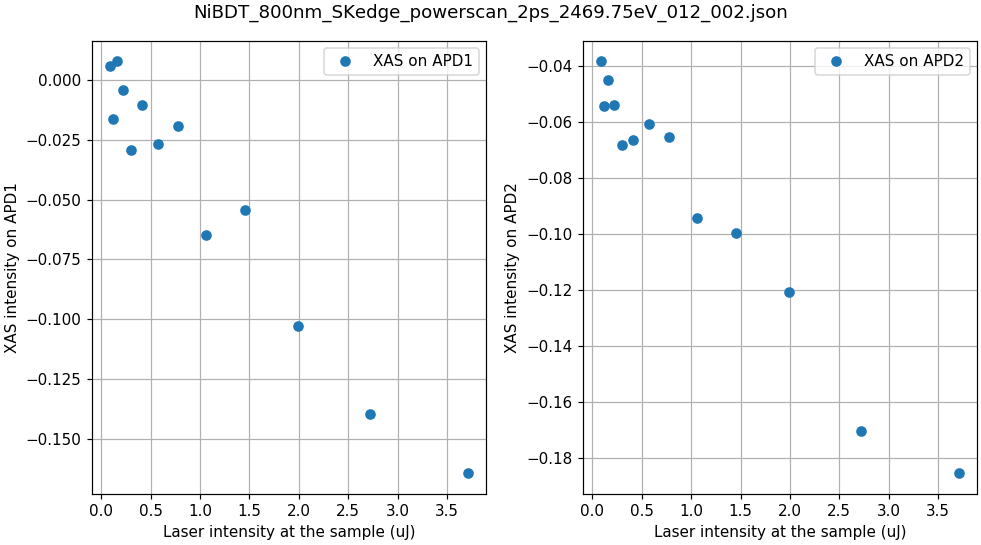

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

xdata = exp_fit(filter_deg, *popt1)
ydata = XAS_APD1_pump_probe

ax1.plot(xdata, ydata, 'o', label='XAS on APD1', linestyle='none')

ax1.set_xlabel('Laser intensity at the sample (uJ)')
ax1.set_ylabel('XAS intensity on APD1')

ax1.grid()
ax1.legend()


xdata = exp_fit(filter_deg, *popt1)
ydata = XAS_APD2_pump_probe

popt, pcov = curve_fit(cosine_fit, xdata, ydata)

ax2.plot(xdata, ydata, 'o', label='XAS on APD2', linestyle='none')

ax2.set_xlabel('Laser intensity at the sample (uJ)')
ax2.set_ylabel('XAS intensity on APD2')

ax2.grid()
ax2.legend()

plt.show()

# Calculate laser fluence 

In [17]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

[71.4375 70.0875 68.625  67.275  65.8125 64.4625 63.     61.65   60.3
 58.8375 57.4875]
[294.57418891 300.29098644 306.16636561 311.28353047 316.48180893
 320.95006004 325.42117553 329.19748117 332.62831071 335.9463667
 338.63389868]


<IPython.core.display.Javascript object>


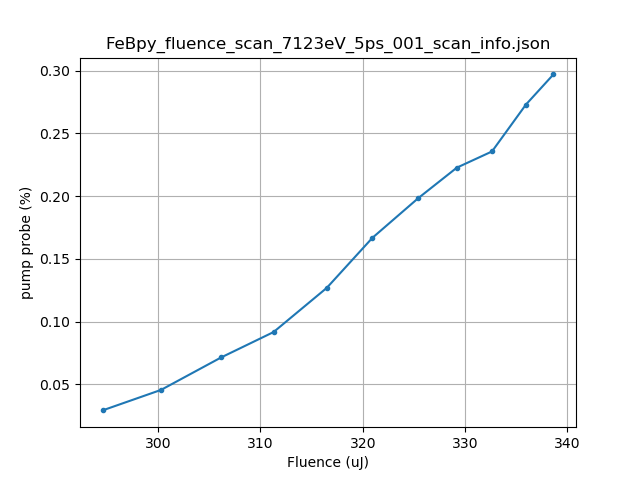

In [20]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(fc.selected.split('/')[-1])
plt.plot(fluences, XAS_pump_probe/XAS_unpump, marker = '.')
plt.grid()
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')
plt.show()